In [6]:
# import libraries
import pandas as pd
import numpy as np
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns
import random
from shapely.geometry import Polygon, Point
from shapely.wkb import loads

# functions
from ipynb.fs.full.demog_functions import clean_data, read_shapefile

Here we are going to use the American Community Survey 5 year estimates from 2017. I got this data from https://factfinder.census.gov/faces/tableservices/jsf/pages/productview.xhtml?pid=ACS_17_5YR_DP05&prodType=table

A few notes about the census tracts, from https://www.easidemographics.com/trshelp/html/census_tract_2.htm:

"Census tracts are identified by a four-digit basic number and may have a two-digit numeric suffix; for example, 6059.02. The decimal point separating the four-digit basic tract number from the two-digit suffix is shown in the printed reports and on census maps. In computer-readable files, the decimal point is implied. Many census tracts do not have a suffix; in such cases, the suffix field is either left blank or is zero-filled. Leading zeros in a census tract number (for example, 002502) are shown only in computer-readable files. Census tract suffixes may range from .01 to .98. For the 1990 census, the .99 suffix was reserved for census tracts/block numbering areas (BNAs) that contained only crews-of-vessels population.

Census tract numbers range from 1 to 9999 and are unique within a county or statistically equivalent entity. The U.S. Census Bureau reserves the basic census tract numbers 9400 to 9499 for census tracts delineated within or to encompass American Indian reservations and offreservation trust lands that exist in multiple states or counties. The number 0000 in computer readable files identifies a census tract delineated to provide complete coverage of water area in territorial seas and the Great Lakes."

In [7]:
# load ACS file
demog_data = clean_data('ACS_17_5YR_B02001/ACS_17_5YR_B02001_with_ann.csv')
demog_data.head()

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)
ipynb.fs.full.demog_functions:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ipynb.fs.full.demog_functions:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
ipynb.fs.full.demog_functions:51: SettingWithCopyWarning: 
A

,GEO_display_label,total_pop,tot_whites,tot_blacks,tot_natives,tot_asians,tot_hawaiians,tot_other,tot_twoplus,census_tract,boro
1,"Census Tract 1, Bronx County, New York",7411,1464,4509,22,125,0,1201,90,Census Tract 1,Bronx County
2,"Census Tract 2, Bronx County, New York",5058,2665,1233,0,158,0,742,260,Census Tract 2,Bronx County
3,"Census Tract 4, Bronx County, New York",5944,2616,1962,30,54,0,1085,197,Census Tract 4,Bronx County
4,"Census Tract 16, Bronx County, New York",6115,2685,2320,0,11,0,989,110,Census Tract 16,Bronx County
5,"Census Tract 19, Bronx County, New York",2817,519,1054,0,78,0,1049,117,Census Tract 19,Bronx County


In [8]:
demog_data['census_tract'].nunique()

1335

From here we're going to work on visualization the NYC shapefiles + color-code the census tracts by the population demographics. <br>

A lot of this was informed by the shapefile tutorial here: https://towardsdatascience.com/mapping-geograph-data-in-python-610a963d2d7f <br>

In [9]:
# initialize visualization
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(15,9))
%matplotlib inline

In [10]:
# connect to shapefile
# 'sf' refers to the extracted shape data
shp_path = 'nyu_2451_34513/nyu_2451_34513.shp' 
sf = shp.Reader(shp_path)

In [11]:
# check that the number of shapes in the shapefile = number of census tracts in the ACS data
len(sf.shapes())

2167

In [12]:
# convert the shape files to dataframe.
# this will help us to connect it to the ACS data

shapedf = read_shapefile(sf)
shapedf.shape

(2167, 13)

In [13]:
shapedf.head()

,statefp,countyfp,tractce,geoid,name,namelsad,mtfcc,funcstat,aland,awater,intptlat,intptlon,coords
0,36,005,000100,36005000100,1,Census Tract 1,G5020,S,1579361,1125765,+40.7934921,-073.8835318,"[(1012569.2511336459, 228983.70178121014), (10..."
1,36,005,000200,36005000200,2,Census Tract 2,G5020,S,455322,926899,+40.8045733,-073.8568585,"[(1021558.2468548007, 236060.6961875496), (102..."
2,36,005,000400,36005000400,4,Census Tract 4,G5020,S,912392,602945,+40.8089152,-073.8504884,"[(1023113.7226130426, 236337.84900077982), (10..."
3,36,005,001600,36005001600,16,Census Tract 16,G5020,S,485079,0,+40.8188478,-073.8580764,"[(1022690.1479616419, 238650.34629134185), (10..."
4,36,005,001900,36005001900,19,Census Tract 19,G5020,S,1643654,1139660,+40.8009990,-073.9093729,"[(1003183.625868493, 233654.4443848743), (1003..."


In [14]:
# the countyfp data encodes which county the census tract belongs in:
shapedf.countyfp.unique()

# create a dict for future reference
boro_conv = {'Bronx County' : '005',
             'Kings County' : '047',
             'New York County' : '061',
             'Queens County' : '081',
             'Richmond County' : '085'}

In [15]:
# inspect example indiv. polygon coords
shapedf.coords[0]

[(1012569.2511336459, 228983.70178121014),
 (1013014.8200885957, 229633.10674261308),
 (1014011.3237288593, 231196.21401121048),
 (1019618.2643002493, 228939.76357493518),
 (1021157.6589785847, 228454.21255563223),
 (1020246.0793601297, 227370.03919457895),
 (1020239.192994262, 227345.6185423889),
 (1019965.736897038, 226696.33411896412),
 (1019943.9354443641, 226645.6595021843),
 (1019901.8806160919, 226244.46516902404),
 (1019974.7621178768, 226020.87092977043),
 (1019646.7632985126, 225917.64773163473),
 (1019228.6193722157, 225721.3935094726),
 (1017767.787780521, 225567.4035371438),
 (1017165.8723576347, 225684.2593608124),
 (1016675.0369173907, 225779.78260795018),
 (1016132.6852262433, 225885.0850526571),
 (1015505.8511700204, 226011.05768620377),
 (1014733.6049008582, 226166.37444046544),
 (1014547.374183576, 227166.96829259966),
 (1014098.9585171401, 227252.03099106718),
 (1013915.8411758967, 227319.93693014226),
 (1011992.4815401686, 228030.6639065681),
 (1012569.2511336459, 

<Figure size 792x648 with 0 Axes>

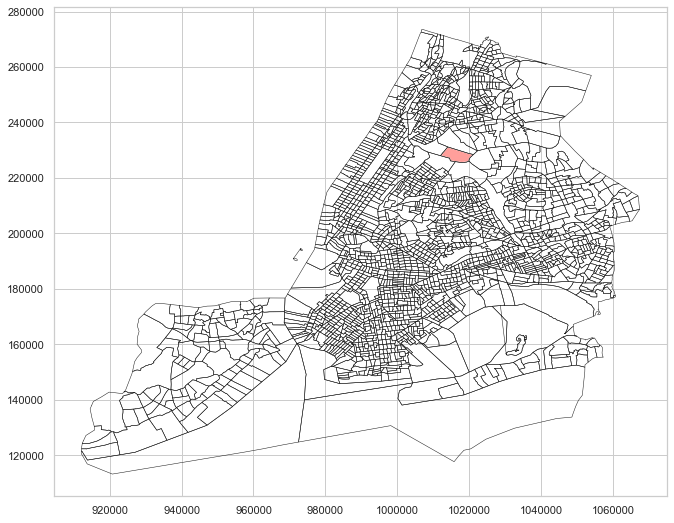

In [83]:
# fill a single census tract within the whole map

# define the boro & census tract that we're interested in plotting
tract = 'Census Tract 1'
boro = boro_conv['Bronx County'] 

# get the associated indices
com_id = shapedf[(shapedf.countyfp==boro) & (shapedf.namelsad == tract)].index.get_values()[0]

#plot
plot_map_fill(com_id, sf, color='r')



<Figure size 792x648 with 0 Axes>

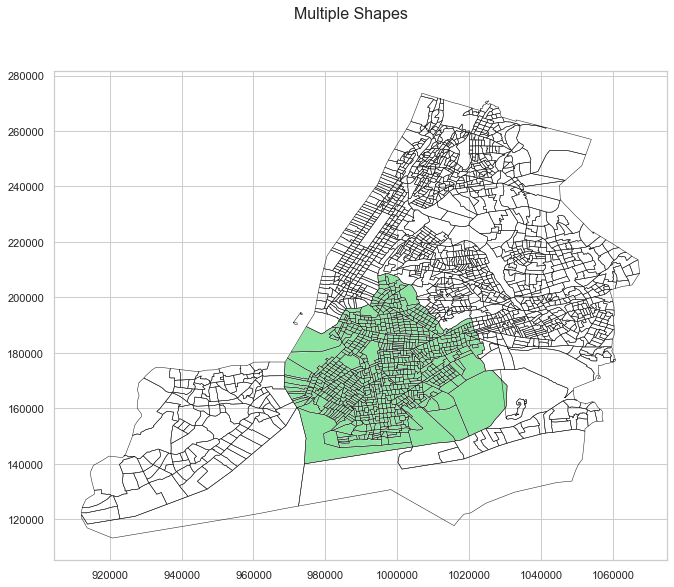

In [77]:
# fill multiple census tracts at once   

# subset by a particular boro
boro = 'Kings County'
boro_id = boro_conv[boro]

tract_list = demog_data.loc[(demog_data.boro == boro),['census_tract']]
tract_list = tract_list.census_tract.str.strip().tolist()
tract_list

tract_id = shapedf[(shapedf['namelsad'].isin(tract_list))&(shapedf['countyfp']==boro_id)].index.get_values()

plot_map_fill_multiples_ids("Multiple Shapes", tract_id, sf, color = 'g')

In [84]:
############################ COME BACK TO THIS
############################ 

# plot full map & color code each census tract by some demographic variable.

# use purple, because NYU
color_sq = ['#dadaebFF','#bcbddcF0','#9e9ac8F0','#807dbaF0','#6a51a3F0','#54278fF0']

plot_map(sf)

NameError: name 'plot_map' is not defined

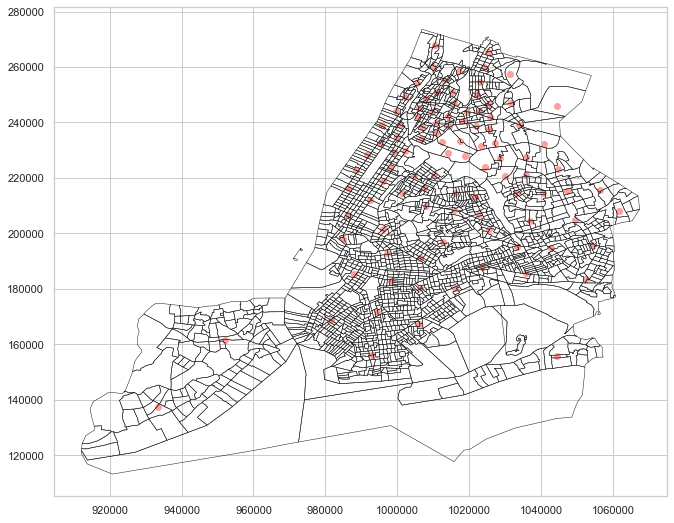

In [16]:
# plot the k-means centroids over the map as a sanity check
from ipynb.fs.full.demog_functions import plot_shape, plot_map

df = pd.read_csv('PseudoSynthDemogData.csv')
centroids = pd.read_csv('kmeans_centroids/k_100.csv',header=None,names=['x','y'],index_col=False)

plot_map(sf)
plt.scatter(centroids.x,centroids.y,color='r')